In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import os
import cv2

In [4]:
base_path = "/content/gdrive/MyDrive/EMMBIOME/SERBIA/Biomedical Imaging/Seminar Paper/ARCADE/syntax/train"
train_images_path = os.path.join(base_path, "images")
train_json_path = os.path.join(base_path, "annotations", "train.json")

Source: https://www.kaggle.com/code/nirmalgaud/artery-segment-classification-and-stenosis-detect

In [ ]:
import json
def load_json(json_path): # mask images were stored as json files, so we need this function to read them
    with open(json_path, 'r') as f: # open in read mode
        data = json.load(f)
    return data

In [ ]:
def create_mask_from_annotations(annotations, image_id, image_shape):
    mask = np.zeros(image_shape, dtype=np.uint8) # create an empty mask filled with zeros that has the same shape as the image

    for ann in annotations:
        if ann['image_id'] == image_id:
            for seg in ann['segmentation']:
                pts = np.array(seg).reshape(-1, 2).astype(np.int32) # convert segmentation points to numpy array and reshape
                cv2.fillPoly(mask, [pts], 255) # fill the polygon defined by the points with white color (255) - the vessel region

    return mask

# Showing the loaded dataset

In [ ]:
def show_images():
    data = load_json(train_json_path) # load the json file
    images = data["images"] # load the list of images from the json file, each entry contains the image id and file name
    annotations = data["annotations"] # load the list of annotations from the json file, each entry contains the image id and segmentation points for the vessel region
    num_samples = 5
    plt.figure(figsize=(10, 4 * num_samples))
    for i, sample in enumerate(images[:num_samples]):
        image_id = sample["id"]
        image_file = sample["file_name"]
        image_path = os.path.join(train_images_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        mask = create_mask_from_annotations(
            annotations, image_id, img.shape
        ) 
        overlay = img_rgb.copy()
        overlay[mask == 255] = [255, 0, 0]
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original: {image_file}")
        plt.axis('off')
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(overlay)
        plt.title("GT Vessel Overlay")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

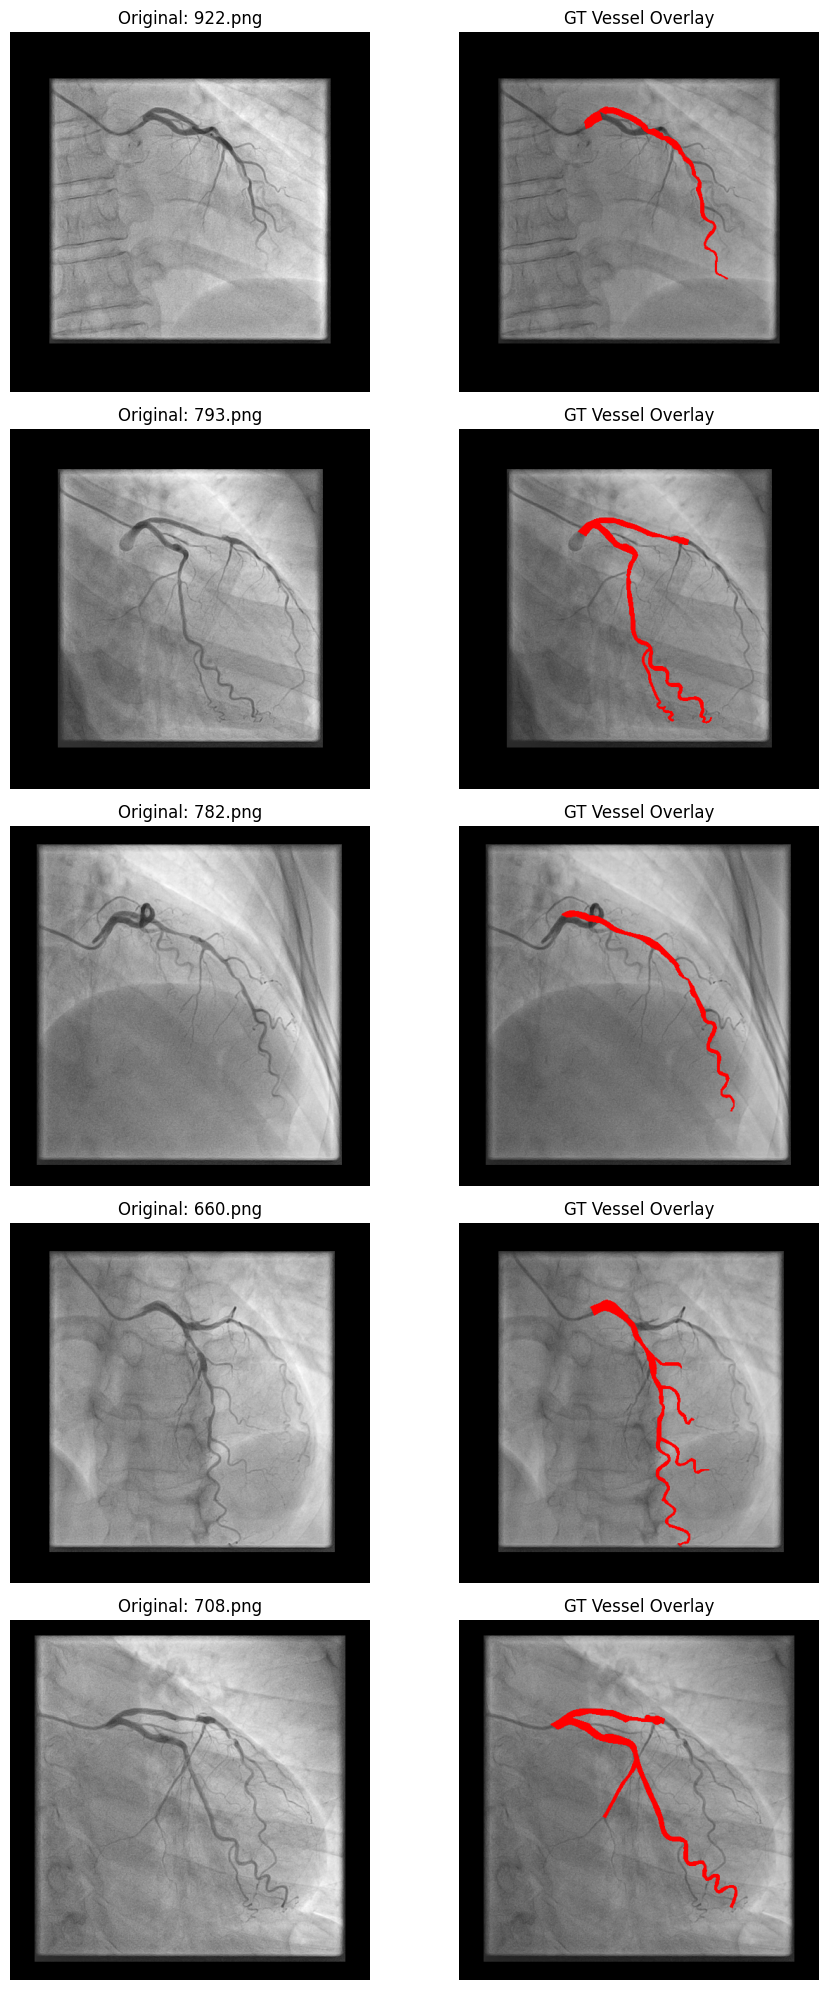

In [8]:
show_images()

# Choosing one image

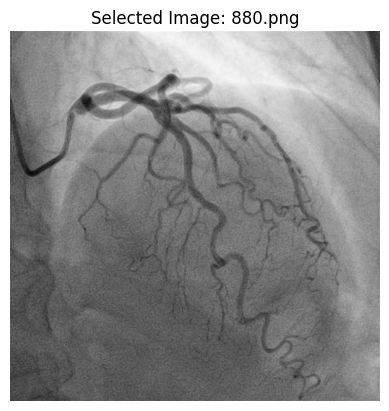

In [ ]:
data = load_json(train_json_path) # load the json file again to get the annotations for the selected image
index = 25 # choose an index to select a specific image and its annotations
sample_image = data['images'][index] # get the image id and file name for the selected image
image_id = sample_image['id'] # get the image id for the selected image, which will be used to find the corresponding annotations for creating the mask
image_file = sample_image['file_name'] # get the file name for the selected image, which will be used to read the image from the disk
image_path = os.path.join(train_images_path, image_file) # construct the full path to the image file by joining the base path for images and the file name of the selected image

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # read the selected image in grayscale mode

plt.imshow(img, cmap='gray')
plt.title(f"Selected Image: {image_file}")
plt.axis('off')
plt.show()

# Showing Histogram

/tmp/ipython-input-2186518417.py:8: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img.ravel(),256,[0,256])


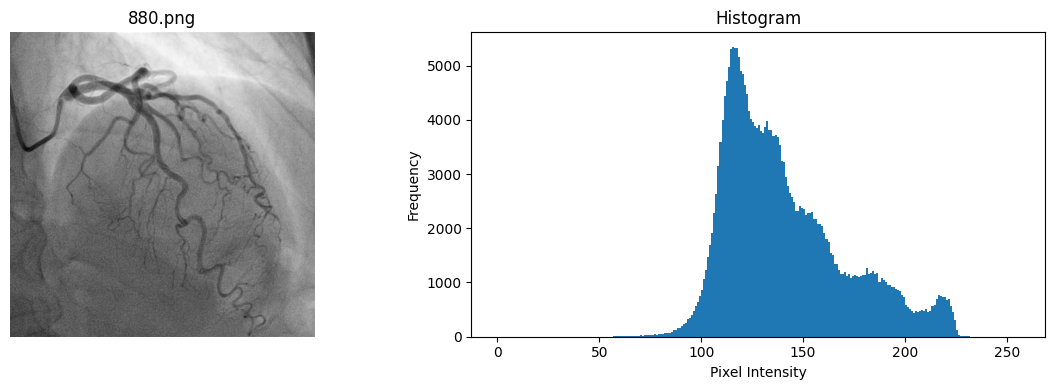

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"{image_file}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(img.ravel(),256,[0,256]) # plot the histogram, ravel() flattens the 2D image into a 1D array, 256 is the number of bins for pixel intensity values from 0 to 255
plt.title("Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Gaussian Blur

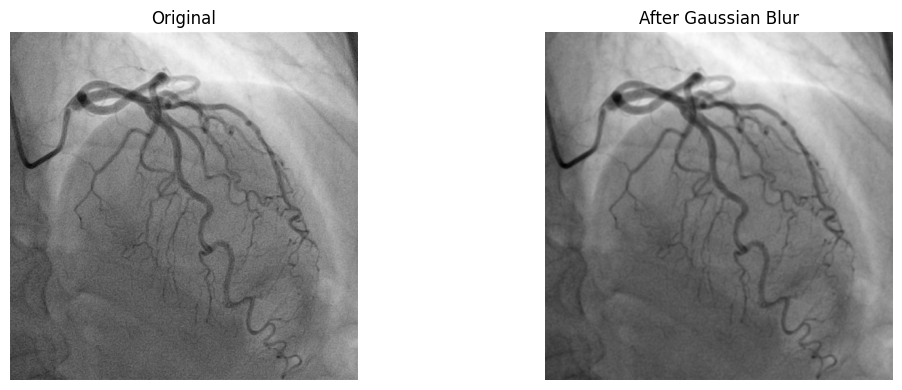

In [ ]:
# To reduce high-frequency noise before enhancing the image's contrast
blur = cv2.GaussianBlur(img, (5, 5), 0) # apply Gaussian blur with a 5x5 kernel to smooth the image and reduce noise
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(blur, cmap='gray')
plt.title("After Gaussian Blur")
plt.axis('off')

plt.tight_layout()
plt.show()

# Contrast Enhancement - Histogram Equalization


For global contrast enhancement, vessels may appear too bright and noise may increase

/tmp/ipython-input-985257515.py:10: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img.ravel(),256,[0,256])
/tmp/ipython-input-985257515.py:19: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img_eq.ravel(),256,[0,256])


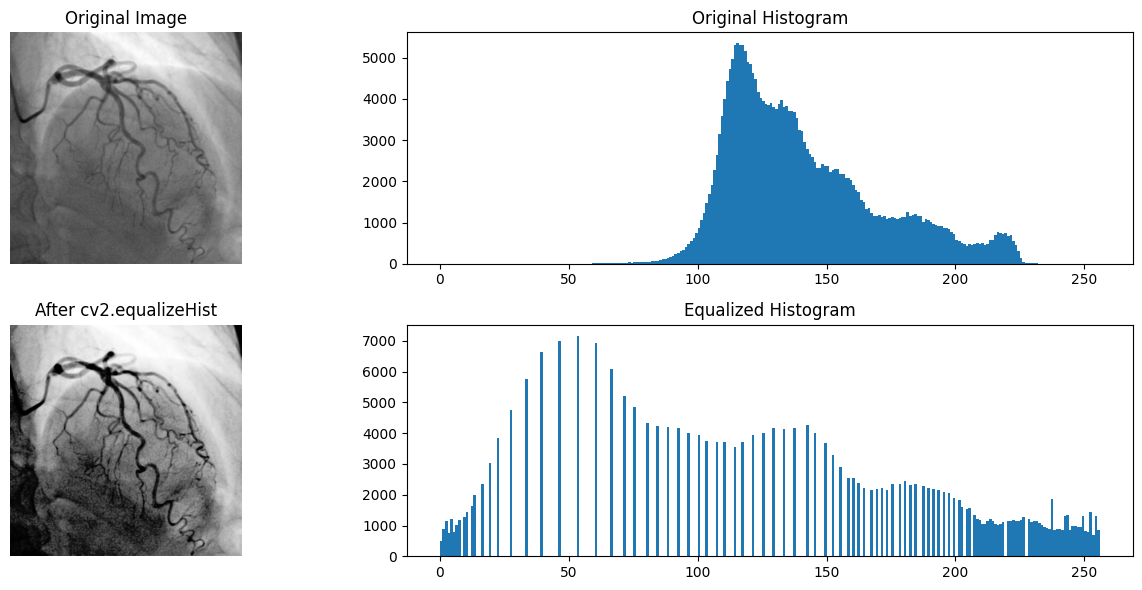

In [ ]:
img_eq = cv2.equalizeHist(blur) # apply histogram equalization to enhance the contrast of the blurred image
plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(blur, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.hist(img.ravel(),256,[0,256])
plt.title("Original Histogram")

plt.subplot(2,2,3)
plt.imshow(img_eq, cmap='gray')
plt.title("After cv2.equalizeHist")
plt.axis('off')

plt.subplot(2,2,4)
plt.hist(img_eq.ravel(),256,[0,256]) # plot the histogram of the equalized image 
plt.title("Equalized Histogram")

plt.tight_layout()
plt.show()

For local contrast enhancement, using CLAHE to prevent noise amplification

/tmp/ipython-input-2277782493.py:12: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img.ravel(),256,[0,256])
/tmp/ipython-input-2277782493.py:21: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(img_clahe.ravel(),256,[0,256])


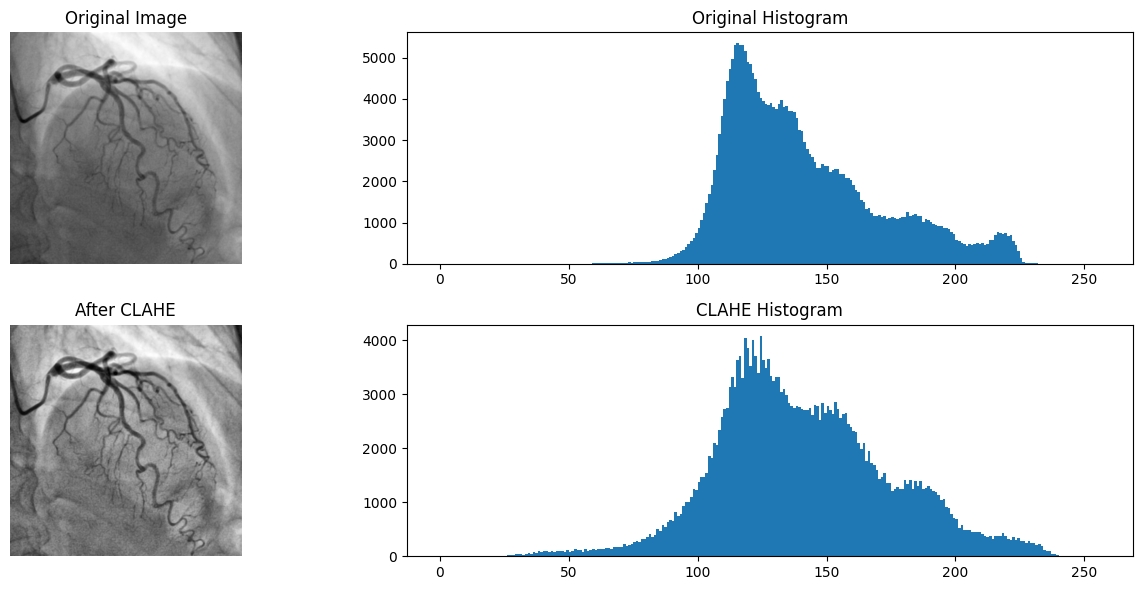

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # create a CLAHE object with a clip limit of 2.0 (avoid noise amplification) and a tile grid size of 8x8
img_clahe = clahe.apply(blur) 

plt.figure(figsize=(14,6))

plt.subplot(2,2,1)
plt.imshow(blur, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.hist(img.ravel(),256,[0,256])
plt.title("Original Histogram")

plt.subplot(2,2,3)
plt.imshow(img_clahe, cmap='gray')
plt.title("After CLAHE")
plt.axis('off')

plt.subplot(2,2,4)
plt.hist(img_clahe.ravel(),256,[0,256])
plt.title("CLAHE Histogram")

plt.tight_layout()
plt.show()

# Adaptive thresholding

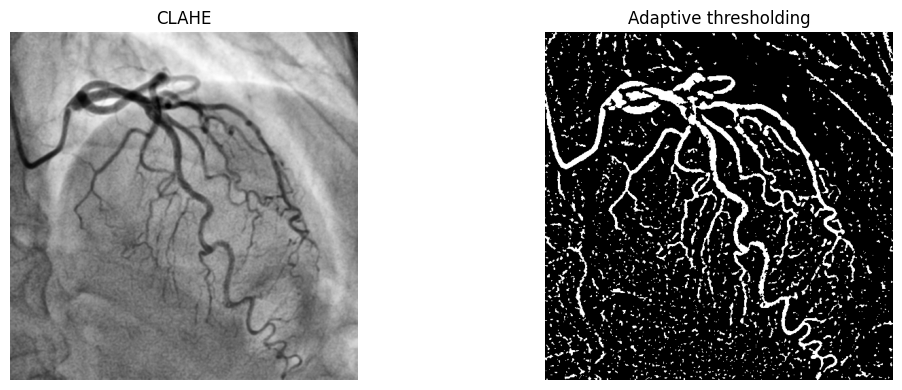

In [ ]:
adaptive = cv2.adaptiveThreshold(img_clahe,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,25,9) # Using inverse thresholding since morphology operates on white regions
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(adaptive, cmap='gray')
plt.title("Adaptive thresholding")
plt.axis('off')

plt.tight_layout()
plt.show()

# Morphological Transformations

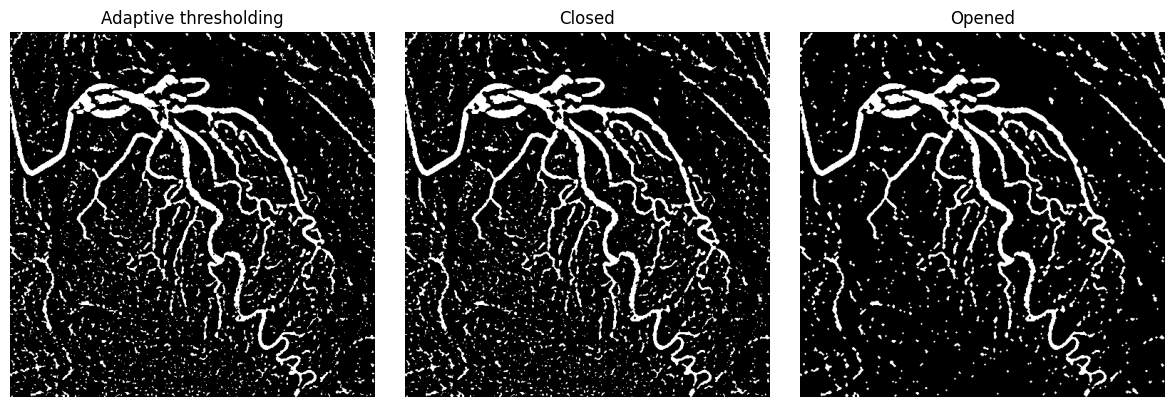

In [58]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3)) # Vessels are tubular, and ellipse preserves vessel geometry better than square
closed = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, kernel, iterations=1) # Connecting broken vessel segments
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1) # Removing noise


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(adaptive, cmap='gray')
plt.title("Adaptive thresholding")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(closed, cmap='gray')
plt.title("Closed")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(opened, cmap='gray')
plt.title("Opened")
plt.axis('off')

plt.tight_layout()
plt.show()

# Connected Component Analysis (CCA)

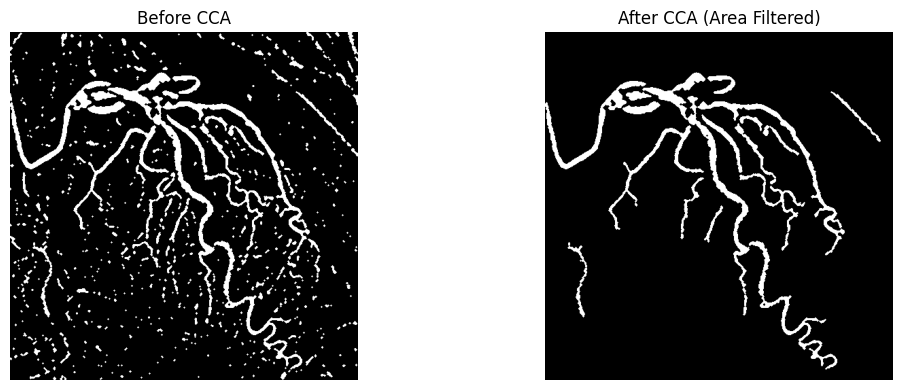

In [ ]:
# Find connected components (vessels), remove small components as noise
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opened, connectivity=8)
min_area = 200 # Minimum area (in pixels) a component must have to be kept
filtered = np.zeros_like(opened)

for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]

    if area >= min_area: # Keep only components whose area is large enough (here >= 200 pixels)
        filtered[labels == label] = 255 # Set pixels of the component to white

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(opened, cmap='gray')
plt.title("Before CCA")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title("After CCA (Area Filtered)")
plt.axis('off')


plt.tight_layout()
plt.show()

In [ ]:
annotations = data["annotations"]
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
mask = create_mask_from_annotations(
    annotations, image_id, img.shape
)
overlay = img_rgb.copy()
overlay[mask == 255] = [255, 0, 0] # Red color for the vessel region from annotations

In [ ]:
final_mask = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
final_mask[filtered == 255] = [0, 255, 0] # Green color for the segmented vessels after CCA and area filtering

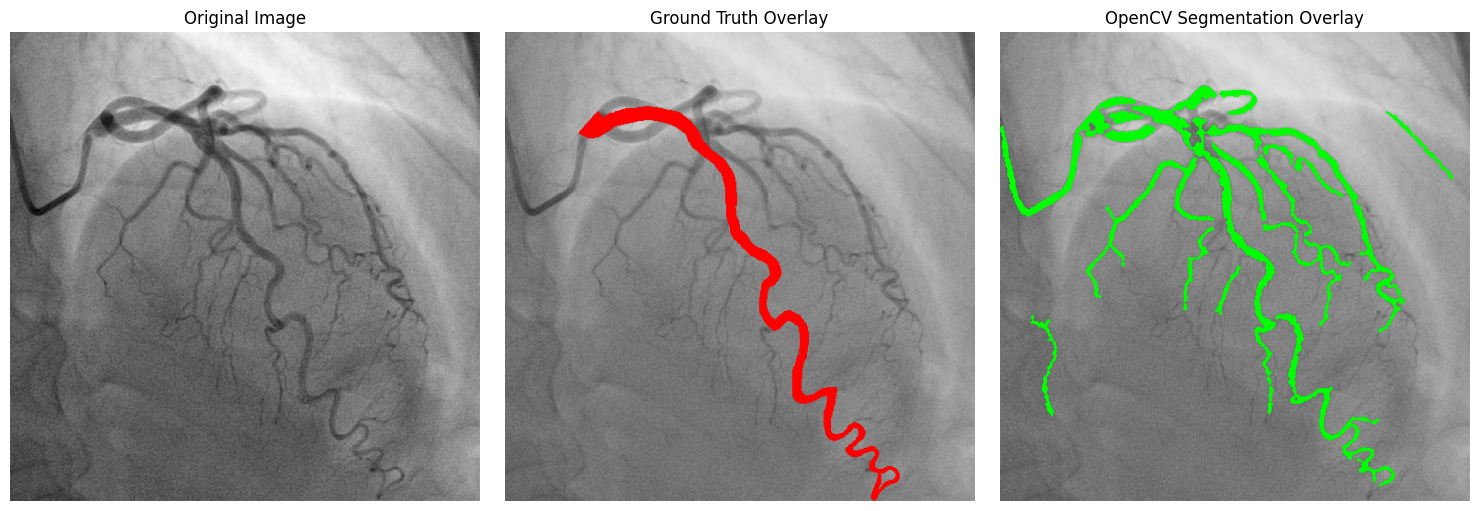

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(overlay)
plt.title("Ground Truth Overlay")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(final_mask)
plt.title("OpenCV Segmentation Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()